In [1]:
#New update

# Setup
import sklearn as sk
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

In [2]:
#sk.__version__

In [3]:
# Import Data
df = pd.read_csv('/mnt/data/prepared.csv', header=0, index_col=0)

df_baseline = pd.read_csv('/mnt/data/churndata.csv', header=0, index_col=0)
create_dummies = pd.get_dummies(df_baseline['churn'],prefix='churn', drop_first=True)  
df_baseline=pd.concat([df_baseline,create_dummies],axis=1)
df_baseline = df_baseline.drop(['churn'], axis=1)
 
columns = list(df.columns)
columns.remove('churn_Y')
y = df["churn_Y"].values
X = df[columns].values

baseline_cols = ['consecmonths', 'KPI_DeviceSat', 'KPI_NetworkQual']
y_baseline = df_baseline['churn_Y'].values
X_baseline = df_baseline[baseline_cols].values

In [4]:
#df_baseline.head()

In [5]:
#dignose dim mismatch when generating predictions on test data
#total = len(create_dummies)
#churn = len(create_dummies[create_dummies.churn_Y == 1])
#no_churn = len(create_dummies[create_dummies.churn_Y == 0])

In [6]:
#print(total, churn, no_churn)

In [7]:
#len(y)

In [8]:
#len(y_baseline)

In [9]:
import pickle

# load baseline model
baseline_model = pickle.load(open('/mnt/results/baseline.pkl', 'rb'))

/usr/local/anaconda/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
#override default values via sysargs
model_ = 'gb' #sys.argv[1]
loss_ = 'exponential' #sys.argv[2]
n_estimators_ = 20 #int(sys.argv[3])
lr = 1 #float(sys.argv[4])

In [11]:
if model_ == 'gb':
    clf = GradientBoostingClassifier(loss = loss_, n_estimators = n_estimators_, learning_rate = lr)
elif model_ == 'ada':
    clf = AdaBoostClassifier(n_estimators = n_estimators_, learning_rate = lr)

clf = clf.fit(X, y)
clfprb = clf.predict_proba(X)

In [12]:
# Evaluate Model
from sklearn import metrics
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
 
tprs = []
aucs = []
accs = []
mean_fpr = np.linspace(0, 1, 100)
 
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = clf.fit(X_train, y_train)
    preds_ = clf.predict(X_test)
    probas_ = clf.predict_proba(X_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_[:, 1])
    
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    accuracy = metrics.accuracy_score(y_test, preds_)
    accs.append(accuracy)
    i += 1
    
mean_acc = np.mean(accs)
std_acc = np.std(accs)
mean_tpr = np.mean(tprs, axis = 0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

In [13]:
y_test.shape

(1587,)

In [14]:
len(probas_)

1587

In [15]:
len(preds_)

1587

In [16]:
len(X_train), len(X_test), len(y_train), len(y_test)

(6352, 1587, 6352, 1587)

In [17]:
y_train.shape

(6352,)

In [18]:
y_test.shape

(1587,)

In [19]:
tprs_baseline = []
aucs_baseline = []
accs_baseline = []
mean_fpr_baseline = np.linspace(0, 1, 100)
 
probas_base_ = baseline_model.predict_proba(X_baseline)
preds_base_ = baseline_model.predict(X_baseline)
fpr_baseline, tpr_baseline, thresholds_baseline = metrics.roc_curve(y_baseline, probas_base_[:, 1])
tprs_baseline.append(np.interp(mean_fpr_baseline, fpr_baseline, tpr_baseline))
tprs[-1][0] = 0.0
roc_auc_baseline = metrics.auc(fpr_baseline, tpr_baseline)
aucs_baseline.append(roc_auc_baseline)
accuracy_baseline = metrics.accuracy_score(y_baseline, preds_base_)
accs_baseline.append(accuracy_baseline)
acc_baseline = np.mean(accs_baseline)
auc_baseline = np.mean(aucs_baseline)

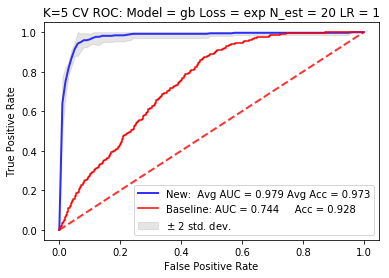

In [37]:
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
 
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=.8, label='New:  Avg AUC = %0.3f Avg Acc = %0.3f' % (mean_auc, mean_acc))
plt.plot(fpr_baseline,tpr_baseline,color='red', label=        'Baseline: AUC = %0.3f     Acc = %0.3f' % (auc_baseline, acc_baseline))
#plt.text(0.6, 0.125, 'Mean AUC = %0.3f' % (mean_auc))
#plt.text(0.6, 0.2, 'Mean Accuracy = %0.3f' % (mean_acc))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

if model_ == 'gb':
    plt.title("K=5 CV ROC: Model = " + model_ + " Loss = " + loss_[:3] + " N_est = " + str(n_estimators_) + " LR = " + str(lr))
elif model_ == 'ada':
    plt.title("K=5 CV ROC: Model = " + model_ + " N_est = " + str(n_estimators_)  + "LR = " + str(lr))
plt.legend(loc="lower right")
 
#write out results
plt.savefig('/mnt/results/AUC_ACC_' + model_ + '_' + str(n_estimators_) +'.png', format='png')
  

In [21]:
preds_.shape

(1587,)

In [22]:
y_test.shape

(1587,)

In [42]:
#make confusion matrix plot
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
 
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
 
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
 
    title:        the text to display at the top of the matrix
 
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
 
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
 
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
 
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
 
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
 
    if cmap is None:
        cmap = plt.get_cmap('Blues')
 
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
 
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
        
        #print(i, j, cm[i,j])
 
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.gcf().subplots_adjust(bottom=0.25)
    plt.savefig('/mnt/results/ConfMatx_' + model_ + '_' + str(n_estimators_) + '.png', format='png')
    plt.savefig('/mnt/results/ConfMatx_New.png', format='png')
    plt.show()
    #plt.gcf().clear()

    fp = float(cm[0,1])
    fn = float(cm[1,0])
    tp = float(cm[1,1])
    tn = float(cm[0,0])
    
    return fp, fn, tp, tn

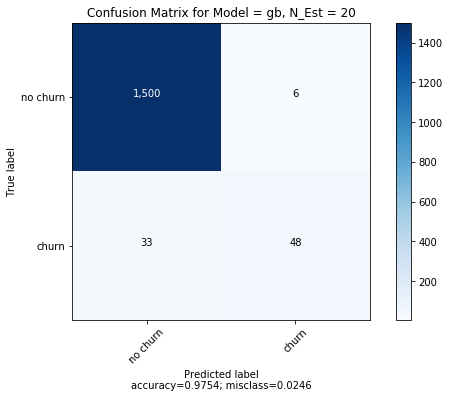

In [43]:
fp, fn, tp, tn = plot_confusion_matrix(cm        = metrics.confusion_matrix(y_test, preds_), 
                    normalize    = False,
                    target_names = ['no churn', 'churn'],
                    title        = "Confusion Matrix for Model = " + model_ + ", N_Est = " + str(n_estimators_))
    

In [45]:
import json

precision = round(tp/(tp+fp),3)
recall = round(tp/(tp+fn),3)
f1 = round(2*((precision*recall)/(precision+recall)),3)

with open('dominostats.json', 'w') as f:
    f.write(json.dumps({"Acc": round(mean_acc, 3), 
                        "AUC": round(mean_auc, 3),
                        "FP": fp,
                        "FN": fn,
                        "Precision": precision,
                        "Recall": recall,
                        "F1": f1}))